In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLA(nn.Module):
  def __init__(self, d_model, n_heads, kv_latent_dim):
    super().__init__()
    self.d_model = d_model
    self.n_heads = n_heads
    self.dh = d_model // n_heads # this is the dimension of each heads

    # we'll be setting the bias to false for matrix multiplication, and using linear to get the benefit of the weights initializing scheme
    self.W_q = nn.Linear(d_model, d_model, bias = False)
    self.W_dkv = nn.Linear(d_model, kv_latent_dim, bias = False) #down projection to latent KV space
    self.W_uk = nn.Linear(kv_latent_dim, d_model, bias = False)
    self.W_uv = nn.Linear(kv_latent_dim, d_model, bias = False)
    self.W_o = nn.Linear(d_model, d_model, bias = False) #output projection for calculating logits matrix

    self.ln = nn.LayerNorm(kv_latent_dim)
    self.register_buffer('absorbed_k', None) # this will hold the absorbed querry component which is the dot product of querry weights and W_uk

  def forward(self, x, kv_cache=None, past_length=0):
    B, S, D = x.size() # since the size would return a tuple of shape of the input. we can store batch size, context size, and the dimension of the embedding

    '''
      now we will compute the absorbed querry for that we know that the absorbed querry matrix would be
          querry weights * weights up projected keys
    '''
    if self.absorbed_k is None:
      absorbed = torch.matmul(self.W_q.weight, self.W_uk.weight) # (Dimension of the embedding, latent dimension) this will multiply the querry weights with tanspose of W_uk
      self.absorbed_k = absorbed.view(self.n_heads, self.dh, -1) # a multidimensional tensor of (number of heads, dimension of head, dimension of latent matrix)

    '''
    now since we have the previously cached latent vectors for the previous tokens, we only need to
    compute the new token's latent vector and append it to the cache. And for the context we only have to multiply the
    absorbed querry with latent cache and the new token
    '''

    new_C_kv = self.ln(self.W_dkv(x)) # multiplying the new token with the down projected weights for keys and values to get the latent key value cache vector for the new token, and ln will normalize the values
    if kv_cache is None:
      c_kv = new_C_kv # if the token being processed is in the earliest batch and the first kv latent cache
    else:
      c_kv = torch.cat((kv_cache, new_C_kv), dim=1)

    S_full = c_kv.size(1)

    '''
    now we would want to be splitting the input into heads for computing the value and querry vectors
    '''

    v_full = self.W_uv(c_kv)
    v = v_full.view(B, S_full, self.n_heads, self.dh).transpose(1,2)

    q = x.view(B, S, self.n_heads, self.dh)

    attn_scores = torch.zeros(B, self.n_heads, S, S_full, device=x.device)
    for h in range(self.n_heads):
      temp = torch.matmul(q[:,:,h], self.absorbed_k[h])
      #now we will be getting the attention score for the new token by multiplying the absorbed querry with new latent kv transpose
      attn_scores[:,h] = torch.bmm(temp, c_kv.transpose(1,2)) # Added () to call the transpose method

    attn_scores = attn_scores / (self.dh ** 0.5) # scaling by the squared root of the dimension of the heads
    mask = torch.tril(torch.ones(S, S_full, device=x.device), diagonal=past_length)
    attn_scores = attn_scores.masked_fill(mask.view(1, 1, S, S_full) == 0, float('-inf')) # this will implement causal attention as soft max as we know e^-inf/ summation of x will give us 0

    attn_weights = F.softmax(attn_scores, dim=-1) #applying softmax

    '''
    all that is left is to calculate the context vectors from each head and combine them to get the context vector
    '''

    out_heads = []
    for h in range(self.n_heads):
      out_heads.append(torch.matmul(attn_weights[:,h], v[:,h]))

    out = torch.cat(out_heads, dim=-1)
    return self.W_o(out), c_kv

#Memory testing

In [13]:
def demo():
   model = MLA(d_model=512, n_heads=8, kv_latent_dim=256)
   x = torch.randn(1, 5, 512)

   out, cache = model(x)
   print(f"Output: {out.shape}, Cache: {cache.shape}")

   std_size = 2 * 2 * 10 * 512 * 4 / 1024
   latent_size = 2 * 10 * 256 * 4 / 1024
   print(f"Memory: Standard={std_size:.1f}KB, Latent={latent_size:.1f}KB, Reduction={std_size/latent_size:.1f}x")

if __name__ == "__main__":
   demo()

Output: torch.Size([1, 5, 512]), Cache: torch.Size([1, 5, 256])
Memory Standard=80.0KB, Latent=20.0KB, Reduction=4.0x


As we can see that there is a reduction in cache size of 4 times

In [14]:
def demo_kv_cache_growth(num_initial_tokens=5, num_new_tokens=3):
   torch.manual_seed(0)

   model = MLA(d_model=8, n_heads=2, kv_latent_dim=4)

   x = torch.randn(1, num_initial_tokens, 8)
   out, cache = model(x)
   print(f"Step 0: Initial input of {num_initial_tokens} tokens → cache shape: {cache.shape}")

   for step in range(1, num_new_tokens + 1):
       new_token = torch.randn(1, 1, 8)
       out, cache = model(new_token, kv_cache=cache, past_length=cache.shape[1])
       print(f"Step {step}: Added 1 token → cache shape: {cache.shape}")

demo_kv_cache_growth(num_initial_tokens=50, num_new_tokens=4)

Step 0: Initial input of 50 tokens → cache shape: torch.Size([1, 50, 4])
Step 1: Added 1 token → cache shape: torch.Size([1, 51, 4])
Step 2: Added 1 token → cache shape: torch.Size([1, 52, 4])
Step 3: Added 1 token → cache shape: torch.Size([1, 53, 4])
Step 4: Added 1 token → cache shape: torch.Size([1, 54, 4])


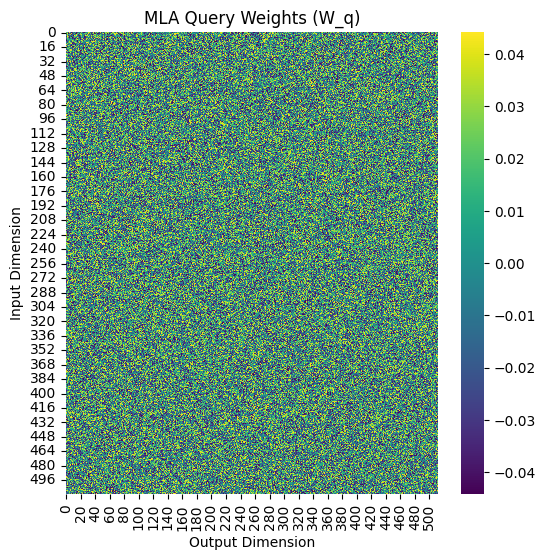

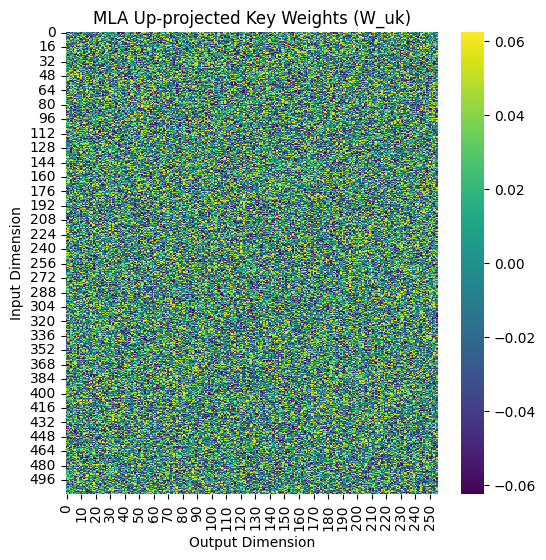

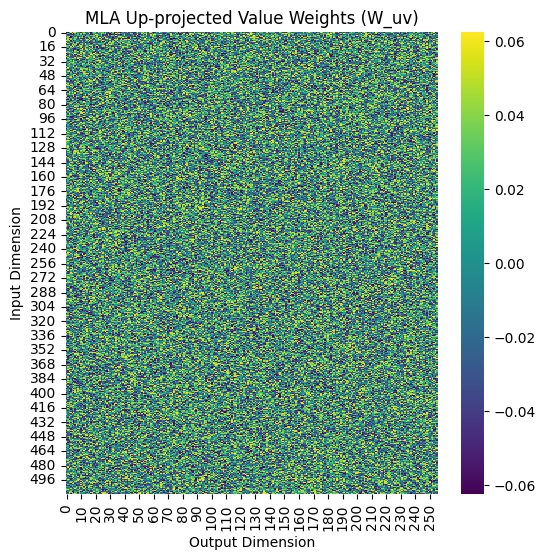

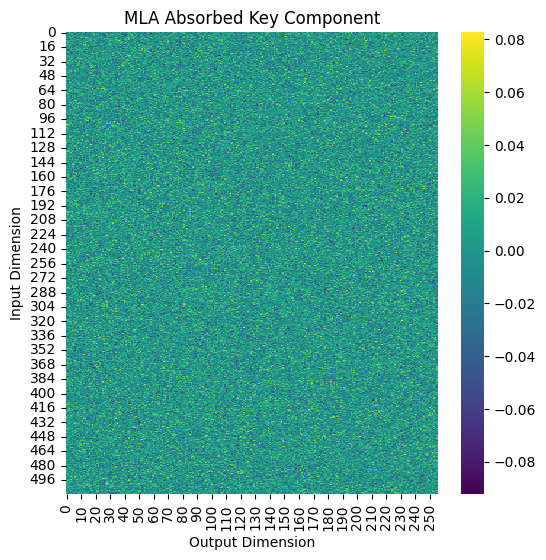

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Helper function to visualize a weight matrix
def visualize_weights(weights, title):
  plt.figure(figsize=(6, 6))
  sns.heatmap(weights.detach().cpu().numpy(), cmap="viridis")
  plt.title(title)
  plt.xlabel("Output Dimension")
  plt.ylabel("Input Dimension")
  plt.show()

# Create a dummy MLA instance
model = MLA(d_model=512, n_heads=8, kv_latent_dim=256)

# Visualize the weight matrices for W_q, W_uk, and W_uv
visualize_weights(model.W_q.weight, "MLA Query Weights (W_q)")
visualize_weights(model.W_uk.weight, "MLA Up-projected Key Weights (W_uk)")
visualize_weights(model.W_uv.weight, "MLA Up-projected Value Weights (W_uv)")

# Visualize the absorbed_k after a forward pass (it's calculated during the first forward pass)
# We need to run a dummy forward pass to populate absorbed_k
x_dummy = torch.randn(1, 10, 512)
out_dummy, cache_dummy = model(x_dummy)

if model.absorbed_k is not None:
    # Reshape absorbed_k for visualization (flatten heads and dimensions)
    absorbed_k_flat = model.absorbed_k.view(model.d_model, -1)
    visualize_weights(absorbed_k_flat, "MLA Absorbed Key Component")
else:
    print("absorbed_k is not populated yet. Run a forward pass first.")



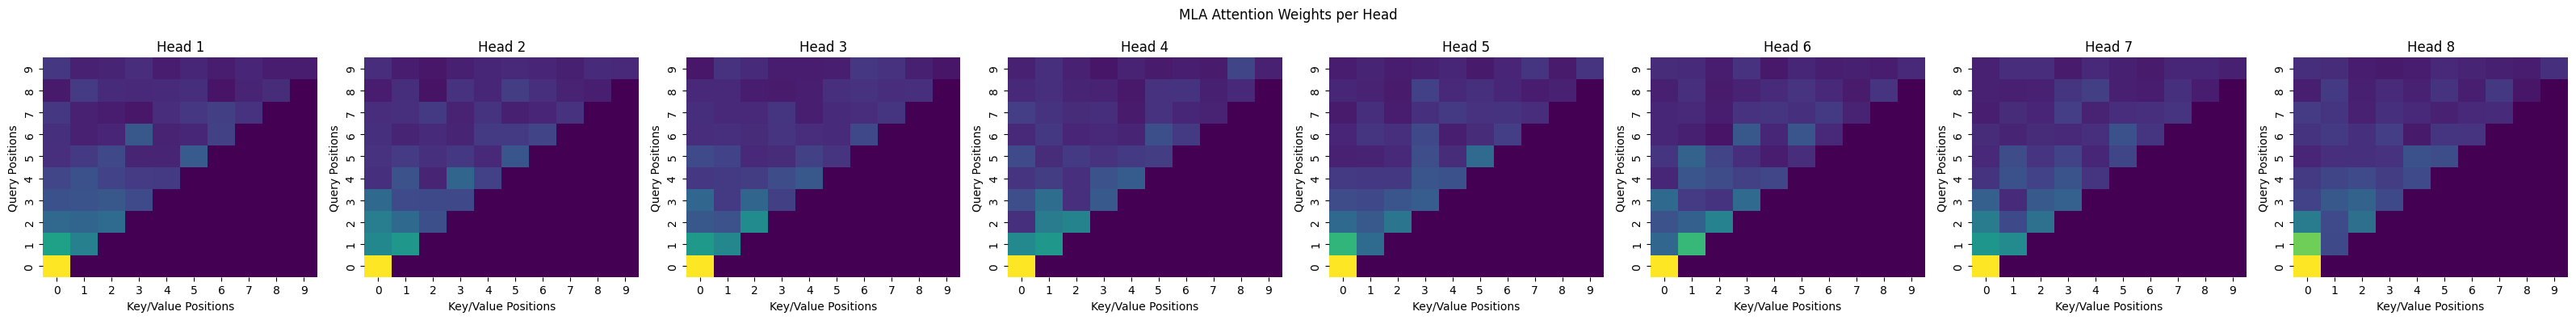

Step 0: Initial input of 5 tokens → cache shape: torch.Size([1, 5, 4]), attn shape: torch.Size([1, 2, 5, 5])


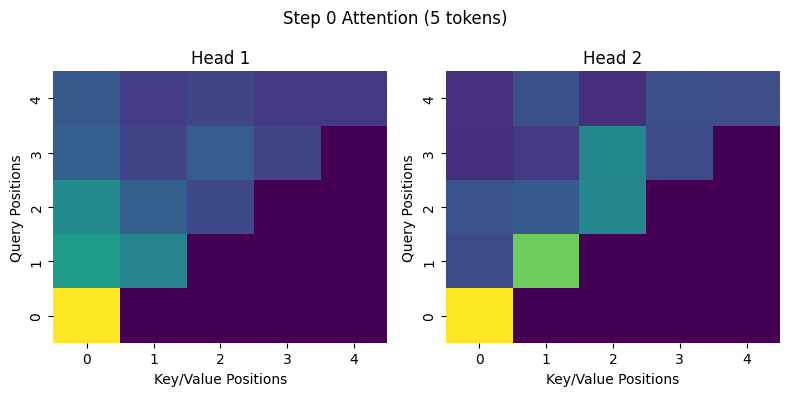

Step 1: Added 1 token → cache shape: torch.Size([1, 6, 4]), attn shape: torch.Size([1, 2, 1, 6])


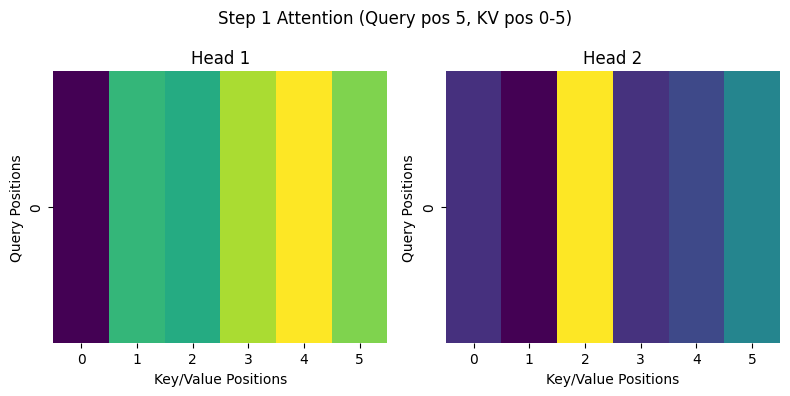

Step 2: Added 1 token → cache shape: torch.Size([1, 7, 4]), attn shape: torch.Size([1, 2, 1, 7])


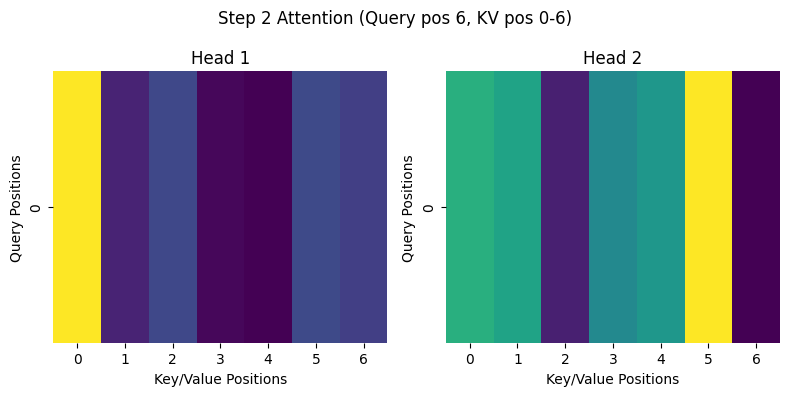

Step 3: Added 1 token → cache shape: torch.Size([1, 8, 4]), attn shape: torch.Size([1, 2, 1, 8])


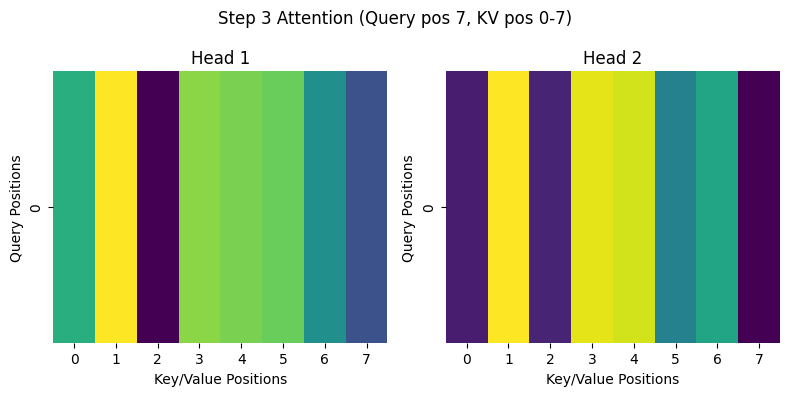

In [16]:


import matplotlib.pyplot as plt
# To visualize attention scores, we need to capture them during the forward pass.
# Modify the MLA class to return attention scores

class MLA_with_attn(nn.Module):
  def __init__(self, d_model, n_heads, kv_latent_dim):
    super().__init__()
    self.d_model = d_model
    self.n_heads = n_heads
    self.dh = d_model // n_heads # this is the dimension of each heads

    self.W_q = nn.Linear(d_model, d_model, bias = False)
    self.W_dkv = nn.Linear(d_model, kv_latent_dim, bias = False) #down projection to latent KV space
    self.W_uk = nn.Linear(kv_latent_dim, d_model, bias = False)
    self.W_uv = nn.Linear(kv_latent_dim, d_model, bias = False)
    self.W_o = nn.Linear(d_model, d_model, bias = False) #output projection for calculating logits matrix

    self.ln = nn.LayerNorm(kv_latent_dim)
    self.register_buffer('absorbed_k', None) # this will hold the absorbed querry component which is the dot product of querry weights and W_uk

  def forward(self, x, kv_cache=None, past_length=0):
    B, S, D = x.size() # since the size would return a tuple of shape of the input. we can store batch size, context size, and the dimension of the embedding

    if self.absorbed_k is None:
      absorbed = torch.matmul(self.W_q.weight, self.W_uk.weight)
      self.absorbed_k = absorbed.view(self.n_heads, self.dh, -1)

    new_C_kv = self.ln(self.W_dkv(x))
    if kv_cache is None:
      c_kv = new_C_kv
    else:
      c_kv = torch.cat((kv_cache, new_C_kv), dim=1)

    S_full = c_kv.size(1)

    v_full = self.W_uv(c_kv)
    v = v_full.view(B, S_full, self.n_heads, self.dh).transpose(1,2)

    q = x.view(B, S, self.n_heads, self.dh)

    attn_scores = torch.zeros(B, self.n_heads, S, S_full, device=x.device)
    for h in range(self.n_heads):
      temp = torch.matmul(q[:,:,h], self.absorbed_k[h])
      attn_scores[:,h] = torch.bmm(temp, c_kv.transpose(1,2)) # Added () to call the transpose method


    attn_scores = attn_scores / (self.dh ** 0.5)
    mask = torch.tril(torch.ones(S, S_full, device=x.device), diagonal=past_length)
    attn_scores = attn_scores.masked_fill(mask.view(1, 1, S, S_full) == 0, float('-inf'))

    attn_weights = F.softmax(attn_scores, dim=-1)

    out_heads = []
    for h in range(self.n_heads):
      out_heads.append(torch.matmul(attn_weights[:,h], v[:,h]))

    out = torch.cat(out_heads, dim=-1)
    return self.W_o(out), c_kv, attn_weights # Return attention weights


def visualize_attention(attn_weights, title):
    """Visualizes the attention weights for each head."""
    B, n_heads, S, S_full = attn_weights.shape
    plt.figure(figsize=(n_heads * 4, 4))

    for h in range(n_heads):
        plt.subplot(1, n_heads, h + 1)
        sns.heatmap(attn_weights[0, h].detach().cpu().numpy(), cmap="viridis", cbar=False)
        plt.title(f"Head {h + 1}")
        plt.xlabel("Key/Value Positions")
        plt.ylabel("Query Positions")
        plt.gca().invert_yaxis() # Invert y-axis to match typical attention plots

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Create an instance of the modified MLA class
model_with_attn = MLA_with_attn(d_model=512, n_heads=8, kv_latent_dim=256)

# Run a forward pass to get attention weights
x_input = torch.randn(1, 10, 512) # Example input sequence of length 10
out_output, cache_output, attention_weights = model_with_attn(x_input)

# Visualize the attention weights
visualize_attention(attention_weights, "MLA Attention Weights per Head")

# Example demonstrating attention with KV cache growth
def demo_attention_with_kv_cache(num_initial_tokens=5, num_new_tokens=3):
    torch.manual_seed(0)

    model = MLA_with_attn(d_model=8, n_heads=2, kv_latent_dim=4)

    x = torch.randn(1, num_initial_tokens, 8)
    out, cache, attn_weights = model(x)
    print(f"Step 0: Initial input of {num_initial_tokens} tokens → cache shape: {cache.shape}, attn shape: {attn_weights.shape}")
    visualize_attention(attn_weights, f"Step 0 Attention ({num_initial_tokens} tokens)")

    current_cache = cache
    for step in range(1, num_new_tokens + 1):
        new_token = torch.randn(1, 1, 8)
        out, new_cache, attn_weights = model(new_token, kv_cache=current_cache, past_length=current_cache.shape[1])
        print(f"Step {step}: Added 1 token → cache shape: {new_cache.shape}, attn shape: {attn_weights.shape}")
        visualize_attention(attn_weights, f"Step {step} Attention (Query pos {current_cache.shape[1]}, KV pos 0-{new_cache.shape[1]-1})")
        current_cache = new_cache

demo_attention_with_kv_cache(num_initial_tokens=5, num_new_tokens=3)
